In [14]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-01-06 14:07:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2020-01-06 14:07:08 (150 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [0]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [16]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [17]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [18]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index


In [20]:
word_index["will"]

4

In [0]:

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [22]:
len(train_sequences[0])


449

In [23]:
len(train_padded[0])

120

In [24]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)


445
(445, 120)


In [25]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 2s - loss: 1.7683 - acc: 0.2972 - val_loss: 1.7371 - val_acc: 0.2270
Epoch 2/30
1780/1780 - 0s - loss: 1.6927 - acc: 0.2365 - val_loss: 1.6412 - val_acc: 0.2270
Epoch 3/30
1780/1780 - 0s - loss: 1.5689 - acc: 0.3365 - val_loss: 1.5021 - val_acc: 0.4764
Epoch 4/30
1780/1780 - 0s - loss: 1.4002 - acc: 0.5236 - val_loss: 1.3373 - val_acc: 0.4517
Epoch 5/30
1780/1780 - 0s - loss: 1.2141 - acc: 0.6691 - val_loss: 1.1559 - val_acc: 0.6315
Epoch 6/30
1780/1780 - 0s - loss: 1.0394 - acc: 0.7320 - val_loss: 1.0006 - val_acc: 0.7416
Epoch 7/30
1780/1780 - 0s - loss: 0.8831 - acc: 0.8275 - val_loss: 0.8621 - val_acc: 0.8472
Epoch 8/30
1780/1780 - 0s - loss: 0.7443 - acc: 0.8781 - val_loss: 0.7456 - val_acc: 0.8697
Epoch 9/30
1780/1780 - 0s - loss: 0.6244 - acc: 0.9124 - val_loss: 0.6334 - val_acc: 0.8921
Epoch 10/30
1780/1780 - 0s - loss: 0.5228 - acc: 0.9225 - val_loss: 0.5447 - val_acc: 0.8944
Epoch 11/30
1780/1780 - 0s - los

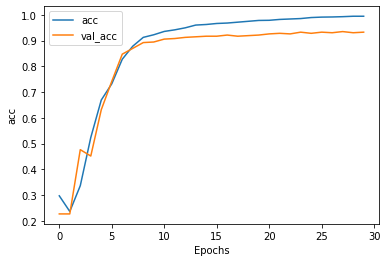

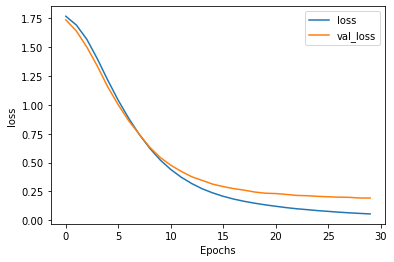

In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [0]:


reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])



In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')